In [1]:
# Necessary imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image

from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score,classification_report
import numpy as np
import os
import cv2
from google.colab import files, drive
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)


In [3]:
def load_dataset():
    if os.path.exists('/content/brain-tumor-mri-dataset'):
        return

    uploaded = files.upload()

    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes.'.format(name=fn, length=len(uploaded[fn])))

    !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
    !kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
    !mkdir brain-tumor-mri-dataset
    !unzip brain-tumor-mri-dataset.zip -d ./brain-tumor-mri-dataset
    clear_output()

load_dataset()

In [4]:
train_dir = '/content/brain-tumor-mri-dataset/Training'
test_dir = '/content/brain-tumor-mri-dataset/Testing'

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False)

test_datagen = ImageDataGenerator(rescale=1./255,
                                   featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False)



train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode= "categorical",
    # color_mode='grayscale'
    )

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode= "categorical",
    # color_mode='grayscale'
    )

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [6]:

base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(256,256,3),
    pooling=None,
    # classes=4,
    classifier_activation="softmax",
)

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False


# model.compile(
#     optimizer=SGD(learning_rate=0.001), #SGD optiziser
#     loss='categorical_crossentropy',
#     metrics= ['accuracy'])

model.compile(
    optimizer=Adam(learning_rate = 0.001), #Adam optimizer
    loss='categorical_crossentropy',
    metrics= ['accuracy'])

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 127, 127, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 127, 127, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 127, 127, 32)         0         ['batch_normalization[0][0

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [8]:
model_es = EarlyStopping(
    monitor = 'loss',
    min_delta = 1e-11,
    patience = 12,
    verbose = 1
    )

model_rlr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    patience = 6,
    verbose = 1
    )

model_mcp = ModelCheckpoint(
    filepath = 'InceptionV3_model_weights.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only = True,
    verbose = 1
    )

history = model.fit(
    train_generator,
    steps_per_epoch=5712//32,
    epochs=20,
    validation_data=test_generator,
    validation_steps= 1311//32,
    callbacks=[model_es, model_rlr, model_mcp]
    )


Epoch 1/20
178/178 [==============================] - ETA: 0s - loss: 2.1733 - accuracy: 0.7996
Epoch 1: val_accuracy improved from -inf to 0.91250, saving model to InceptionV3_model_weights.h5
178/178 [==============================] - 48s 161ms/step - loss: 2.1733 - accuracy: 0.7996 - val_loss: 0.3404 - val_accuracy: 0.9125 - lr: 0.0010
Epoch 2/20
178/178 [==============================] - ETA: 0s - loss: 0.2757 - accuracy: 0.9178
Epoch 2: val_accuracy did not improve from 0.91250
178/178 [==============================] - 25s 138ms/step - loss: 0.2757 - accuracy: 0.9178 - val_loss: 0.4218 - val_accuracy: 0.8984 - lr: 0.0010
Epoch 3/20
178/178 [==============================] - ETA: 0s - loss: 0.1285 - accuracy: 0.9574
Epoch 3: val_accuracy did not improve from 0.91250
178/178 [==============================] - 26s 146ms/step - loss: 0.1285 - accuracy: 0.9574 - val_loss: 0.4592 - val_accuracy: 0.8953 - lr: 0.0010
Epoch 4/20
178/178 [==============================] - ETA: 0s - loss: 0

In [9]:
# Evaluating the model
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples//32)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

40/40 [==============================] - 4s 110ms/step - loss: 0.1230 - accuracy: 0.9773
Test Loss: 0.12301
Test Accuracy: 0.97734


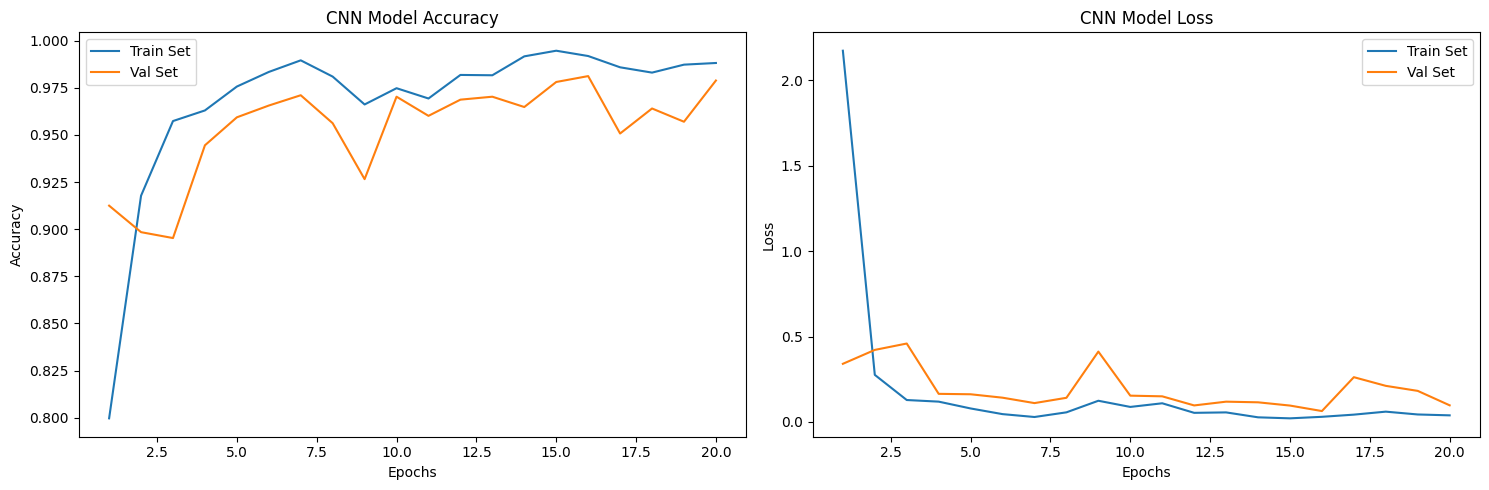

In [10]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model Loss')

plt.tight_layout()
plt.show()

In [11]:
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']


In [12]:
all_pred = []
all_true = []

# Assuming `test` is an image generator or a dataset generator
# Iterate through the generator to process all images
for i in range(41):  # Replace `total_iterations` with the actual number of iterations needed
    X_test, y_test = next(test_generator)
    pred = model.predict(X_test)

    pred = np.argmax(pred, axis=1)
    y_test_new = np.argmax(y_test, axis=1)

    # Append predictions and true labels to the respective lists
    all_pred.extend(pred)
    all_true.extend(y_test_new)

# Calculate the classification report using all predictions and true labels
clear_output()
print(classification_report(all_true, all_pred, target_names=categories))

              precision    recall  f1-score   support

      glioma       0.99      0.95      0.97       300
  meningioma       0.93      0.97      0.95       306
     notumor       0.99      1.00      0.99       405
   pituitary       1.00      0.98      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



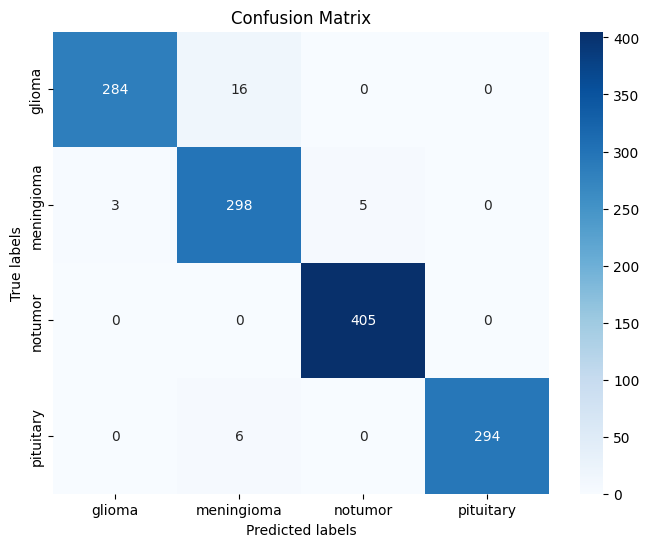

In [13]:
conf_matrix = confusion_matrix(all_true, all_pred)
# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
